# Flow inside a pipe (2D)
This notebook implements an unsteady incompressible Navier-Stokes solver for the flow inside a tube.

The problem is strong form reads:
\begin{equation}
\left\{
\begin{array}{ll}
    \nabla \cdot \mathbf{u} =0& in\;\Omega\\
    \displaystyle \frac{\partial \mathbf{u}}{\partial t}+\left(\mathbf{u}\cdot \nabla\right)\mathbf{u}= \frac{1}{Re}\Delta \mathbf{u}-\nabla p & in\;\Omega\\ & \\
    \left. \mathbf{u}\right|_{t=0}=\mathbf{0} & in\;\Omega\\ & \\
    \mathbf{u} = \mathbf{i} & on\;\Gamma_{in}\\
    \mathbf{u} = \mathbf{0} & on\;\Gamma_w\\
    \mathbf{u}\cdot \mathbf{n} = \mathbf{0} & on\;\Gamma_{sym}\\
    \left(\frac{1}{Re}\nabla \mathbf{u}-p\mathbb{I}\right)\cdot \mathbf{n}=\mathbf{0} & on \;\Gamma_{out}
\end{array}
\right.
\end{equation}

In [1]:
import tqdm
import numpy as np

# Mesh generation
import dolfinx
from mpi4py import MPI
from dolfinx import mesh
from dolfinx.io import gmshio, XDMFFile
from dolfinx import fem
from dolfinx.fem import Function, FunctionSpace, dirichletbc, locate_dofs_topological, form, assemble_scalar
import ufl
from ufl import grad, div, nabla_grad, dx, inner, dot
from petsc4py import PETSc

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

We need to define the variational formulations for the time advancement loop. Let's start with the projection step
\begin{equation}
\left\{
\begin{array}{ll}
    \displaystyle \frac{\tilde{\mathbf{u}}-\mathbf{n}^n}{\Delta t}+\left(\mathbf{u}^n\cdot \nabla\right)\tilde{\mathbf{u}}= \frac{1}{Re}\Delta \tilde{\mathbf{u}}-\nabla p^n & in\;\Omega\\ & \\
    \tilde{\mathbf{u}} = \mathbf{u}_{in} & on\;\Gamma_{in}\\
    \tilde{\mathbf{u}} = \mathbf{0} & on\;\Gamma_w\\
    \frac{1}{Re}\nabla\tilde{\mathbf{u}}\cdot \mathbf{n}=\mathbf{g} & on \;\Gamma_{out}
\end{array}
\right.
\end{equation}
whose weak formulation reads
\begin{equation}
\int_\Omega \tilde{\mathbf{u}}\cdot \mathbf{v}\,d\Omega + \Delta t \int_\Omega \left(\mathbf{u}^n\cdot \nabla\right)\tilde{\mathbf{u}}\cdot \mathbf{v}\,d\Omega + \frac{ \Delta t}{Re} \int_\Omega\nabla \tilde{\mathbf{u}}\cdot \nabla \mathbf{v}\,d\Omega =
\int_\Omega {\mathbf{u}}^n\cdot \mathbf{v}\,d\Omega -  \Delta t\int_\Omega \nabla p^n\cdot \mathbf{v}\,d\Omega 
\end{equation}

The projection step consists in a Poisson problem, i.e.
\begin{equation}
\left\{
    \begin{array}{ll}
        -\Delta \delta p=-\frac{1}{\Delta t}\nabla\cdot \tilde{\mathbf{u}} & in\;\Omega\\
        \delta p = 0 & on\;\Gamma_{out}\\
        \nabla\delta p\cdot \mathbf{n}=0& on\;\partial\Omega\setminus \Gamma_{out}
    \end{array}
\right.
\end{equation}
whose weak formulation reads
\begin{equation}
\int_\Omega \nabla \delta p\cdot \nabla q\,d\Omega = -\frac{1}{\Delta t}\int_\Omega q\nabla \cdot \tilde{\mathbf{u}}\,d\Omega
\qquad \forall q\in\mathcal{Q}
\end{equation}

Then, a third auxiliary variational problem is defined to update the velocity
\begin{equation}
\int_\Omega \mathbf{u}^{n+1} \cdot \mathbf{v} \,d\Omega= \int_\Omega\left( \tilde{\mathbf{u}}-\Delta t\nabla\delta p\right) \cdot \mathbf{v} \,d\Omega
\end{equation}

Let us solve the problem considering a $Re = 20$.

In [2]:
class InletVelocity():
    def __init__(self, u_in, gdim):
        self.u_in = u_in
        self.gdim = gdim

    def __call__(self, x):
        values = np.zeros((self.gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = self.u_in
        return values


class unsteadyNS():
    def __init__(self, meshFile, gdim, inl_marker, bottom_marker, top_marker, out_marker):

        self.domain, _, self.ft = gmshio.read_from_msh(meshFile+".msh", MPI.COMM_WORLD, gdim = gdim)
        self.gdim = gdim
        self.fdim = gdim - 1
        self.P2 = ufl.VectorElement("Lagrange", self.domain.ufl_cell(), 2)
        self.V = FunctionSpace(self.domain, self.P2)
        self.P1 = ufl.FiniteElement("Lagrange", self.domain.ufl_cell(), 1)
        self.Q = FunctionSpace(self.domain, self.P1)

        self.u = ufl.TrialFunction(self.V)
        self.v = ufl.TestFunction(self.V)
        self.uOld = Function(self.V)
        self.uTilde = Function(self.V)
        self.u_sol = Function(self.V)

        self.p = ufl.TrialFunction(self.Q)
        self.q = ufl.TestFunction(self.Q)
        self.pOld = Function(self.Q)
        self.deltaP = Function(self.Q)
        self.p_sol = Function(self.Q)

        self.inl_marker = inl_marker
        self.bottom_marker = bottom_marker
        self.top_marker = top_marker
        self.out_marker = out_marker

        self.ds = ufl.Measure('ds', domain=self.domain, subdomain_data=self.ft)
        self.L = self.domain.comm.allreduce(assemble_scalar(form(0.5 * self.ds(self.top_marker))), op=MPI.SUM)
        self.R = self.domain.comm.allreduce(assemble_scalar(form(1.0 * self.ds(self.inl_marker))),  op=MPI.SUM)

        # Stabilisation 
        self.P0 = FunctionSpace(self.domain, ("DG", 0))
        self.deltaK = Function(self.P0)
        self.uK = Function(self.P0)

    def parameters(self, u_in, Re):
        self.u_in = u_in
        self.Re = Re
        self.nuValue = self.u_in * self.R / self.Re

        print('The Reynolds number is {:.0f}'.format(Re)+' and the viscosity is {:.2e}'.format(self.nuValue)+' [cm2/s]')

        self.nu = fem.Constant(self.domain, PETSc.ScalarType(self.nuValue))

        self.inlet_velocity = InletVelocity(self.u_in, self.gdim)
        self.in_velocity = Function(self.V)
        self.in_velocity.interpolate(self.inlet_velocity)
        self.bc_in = dirichletbc(self.in_velocity, 
                                 locate_dofs_topological(self.V, self.fdim, self.ft.find(self.inl_marker)))

        self.u_nonslip = np.array((0,) * self.domain.geometry.dim, dtype=PETSc.ScalarType)
        self.bc_w = dirichletbc(self.u_nonslip, 
                                locate_dofs_topological(self.V, self.fdim, self.ft.find(self.bottom_marker)), 
                                self.V)

        self.bc_sym = dirichletbc(self.u_nonslip[1], 
                                  locate_dofs_topological(self.V.sub(1), self.fdim, self.ft.find(self.top_marker)), 
                                  self.V.sub(1))

        self.bc_u = [self.bc_w, self.bc_in, self.bc_sym]
        self.bc_p = [dirichletbc(PETSc.ScalarType(0), 
                                 locate_dofs_topological(self.Q, self.fdim, self.ft.find(self.out_marker)), 
                                 self.Q)]

    def assemble(self, dt, stabilisation):
        self.dt = dt
        self.NS_a_ = (inner(self.u,self.v) / self.dt + 
                      inner(dot(self.uOld, nabla_grad(self.u)), self.v) + 
                      inner(self.nu * grad(self.u), grad(self.v))) * dx
        self.NS_L_ = (inner(self.uOld / self.dt - grad(self.pOld), self.v)) * dx

        # Streamline diffusion stabilisation
        self.stab = stabilisation
        if self.stab == 1:
            print('The streamline diffusion stabilisation is implemented')
            self.NS_a_ += (self.deltaK * inner(dot(self.uOld, nabla_grad(self.u)), dot(self.uOld, nabla_grad(self.v)))) * dx
        elif self.stab == 2:
            print('The SUPG stabilisation is implemented')
            self.NS_a_ += (self.deltaK * inner( self.u / self.dt + dot(self.uOld, nabla_grad(self.u)) - 
                                                self.nu * div(grad(self.u)),
                                                dot(self.uOld, nabla_grad(self.v)) + 0.5 * (div(self.uOld)) * self.v)) * dx
            self.NS_L_ += (self.deltaK * inner(self.uOld / self.dt - grad(self.pOld),
                                               dot(self.uOld, nabla_grad(self.v)) + 0.5 * (div(self.uOld)) * self.v)) * dx
                           
        else:
            print('No stabilisation is implemented')

        self.NS_a = form(self.NS_a_)
        self.NS_L = form(self.NS_L_)
        self.NS_A = fem.petsc.create_matrix(self.NS_a)
        self.NS_b = fem.petsc.create_vector(self.NS_L)

        self.solver1 = PETSc.KSP().create(self.domain.comm)
        self.solver1.setOperators(self.NS_A)
        self.solver1.setType(PETSc.KSP.Type.BCGS)
        self.pc1 = self.solver1.getPC()
        self.pc1.setType(PETSc.PC.Type.JACOBI)
        # self.solver1.setType("preonly")
        # self.solver1.getPC().setType("lu")
        # self.solver1.getPC().setFactorSolverType("superlu_dist")

        self.Poisson_a = form(inner(grad(self.p), grad(self.q)) * dx)
        self.Poisson_L = form(- 1. / self.dt * inner(div(self.uTilde), self.q) * dx)

        self.Poisson_A = fem.petsc.assemble_matrix(self.Poisson_a, bcs = self.bc_p)
        self.Poisson_A.assemble()
        self.Poisson_b = fem.petsc.create_vector(self.Poisson_L)

        self.solver2 = PETSc.KSP().create(self.domain.comm)
        self.solver2.setOperators(self.Poisson_A)
        self.solver2.setType(PETSc.KSP.Type.CG)
        self.pc2 = self.solver2.getPC()
        self.pc2.setType(PETSc.PC.Type.SOR)
        # self.solver2.setType("preonly")
        # self.solver2.getPC().setType("lu")
        # self.solver2.getPC().setFactorSolverType("superlu_dist")

        self.update_a = form(inner(self.u, self.v) * dx)
        self.update_L = form(inner(self.uTilde - self.dt * grad(self.deltaP), self.v) * dx)

        self.update_A = fem.petsc.assemble_matrix(self.update_a)
        self.update_A.assemble()
        self.update_b = fem.petsc.create_vector(self.update_L)

        self.solver3 = PETSc.KSP().create(self.domain.comm)
        self.solver3.setOperators(self.update_A)
        self.solver3.setType(PETSc.KSP.Type.CG)
        self.pc3 = self.solver3.getPC()
        self.pc3.setType(PETSc.PC.Type.SOR)
        # self.solver3.setType("preonly")
        # self.solver3.getPC().setType("lu")
        # self.solver3.getPC().setFactorSolverType("superlu_dist")

    def solve(self, T):
        num_steps = int(T/self.dt)
        t = 0.

        self.u_sol.name = "U"
        self.p_sol.name = "p"

        u_xdmf = XDMFFile(self.domain.comm, "U_"+str(self.Re)+".xdmf", "w")
        u_xdmf.write_mesh(self.domain)
        u_xdmf.write_function(self.u_sol, t)

        p_xdmf = XDMFFile(self.domain.comm, "p_"+str(self.Re)+".xdmf", "w")
        p_xdmf.write_mesh(self.domain)
        p_xdmf.write_function(self.p_sol, t)

        kk = 1

        progress = tqdm.tqdm(desc="Solving NS for the velocity profile", total=num_steps)
        for ii in range(num_steps):
            progress.update(1)
            t += self.dt

            # Update uK and deltaK for the stabilisation term
            if self.stab == 1:
                self.uK.interpolate(fem.Expression(ufl.algebra.Power(dot(self.uOld, self.uOld), 0.5),
                                                   self.P0.element.interpolation_points() ))
                self.deltaK.interpolate(fem.Expression(ufl.CellDiameter(self.domain) / ufl.Max(1e-10, self.uK),
                                                       self.P0.element.interpolation_points() ))
            if self.stab == 2:
                delta = fem.Constant(self.domain, PETSc.ScalarType(0.1))
                self.uK.interpolate(fem.Expression(ufl.algebra.Power(dot(self.uOld, self.uOld), 0.5),
                                                   self.P0.element.interpolation_points() ))
                self.deltaK.interpolate(fem.Expression(delta / ufl.Max(self.uK / ufl.CellDiameter(self.domain),
                                                                       self.nu / ufl.CellDiameter(self.domain)**2),
                                                       self.P0.element.interpolation_points() ))

            # Predictor
            self.NS_A.zeroEntries()
            fem.petsc.assemble_matrix(self.NS_A, self.NS_a, bcs = self.bc_u)
            self.NS_A.assemble()

            with self.NS_b.localForm() as loc:
                loc.set(0)
            fem.petsc.assemble_vector(self.NS_b, self.NS_L)
            fem.petsc.apply_lifting(self.NS_b, [self.NS_a], [self.bc_u])
            self.NS_b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            fem.petsc.set_bc(self.NS_b, self.bc_u)

            self.solver1.solve(self.NS_b, self.uTilde.vector)
            self.uTilde.x.scatter_forward()

            # Projection
            with self.Poisson_b.localForm() as loc:
                loc.set(0)
            fem.petsc.assemble_vector(self.Poisson_b, self.Poisson_L)
            fem.petsc.apply_lifting(self.Poisson_b, [self.Poisson_a], [self.bc_p])
            self.Poisson_b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            fem.petsc.set_bc(self.Poisson_b, self.bc_p)

            self.solver2.solve(self.Poisson_b, self.deltaP.vector)
            self.deltaP.x.scatter_forward()

            # Correction
            with self.update_b.localForm() as loc:
                loc.set(0)
            fem.petsc.assemble_vector(self.update_b, self.update_L)
            self.update_b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            self.solver3.solve(self.update_b, self.u_sol.vector)
            self.u_sol.x.scatter_forward()

            self.p_sol.vector.axpy(1, self.deltaP.vector)
            self.p_sol.x.scatter_forward()

            # Save solution
            if (np.isclose(t, 1 * kk * self.dt)):
                u_xdmf.write_function(self.u_sol, t)
                p_xdmf.write_function(self.p_sol, t)
                kk += 1

            # Update old
            with self.u_sol.vector.localForm() as loc_, self.uOld.vector.localForm() as loc_n:
                loc_.copy(loc_n)
            with self.p_sol.vector.localForm() as loc_, self.pOld.vector.localForm() as loc_n:
                loc_.copy(loc_n)
                
        u_xdmf.close()
        p_xdmf.close()

        return self.u_sol


Let's solve the problem

In [3]:
gdim = 2
inl_marker  = 10
bottom_marker = 20
top_marker = 30
out_marker  = 40
velocityProblem = unsteadyNS('channel2D', gdim, inl_marker, bottom_marker, top_marker, out_marker)

pitch = 4.36
u_in = 1 # cm/s
Re = 5000
velocityProblem.parameters(u_in, Re)

dt = 5e-3
stab = 2
velocityProblem.assemble(dt, stab)

print(' ')
T = 1
u_sol = velocityProblem.solve(T)

Info    : Reading 'channel2D.msh'...
Info    : 9 entities
Info    : 6000 nodes
Info    : 6317 elements
Info    : Done reading 'channel2D.msh'
The Reynolds number is 5000 and the viscosity is 6.00e-05 [cm2/s]
The SUPG stabilisation is implemented
 


Solving NS for the velocity profile: 100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


In [4]:
max(velocityProblem.deltaK.x.array.real)

0.0690032407515131

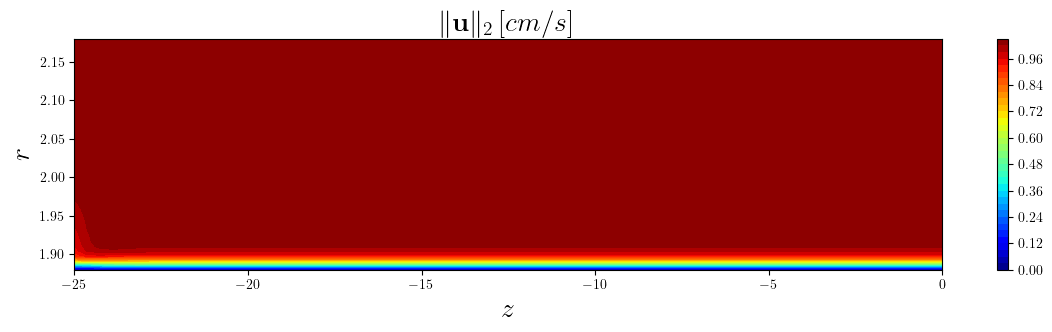

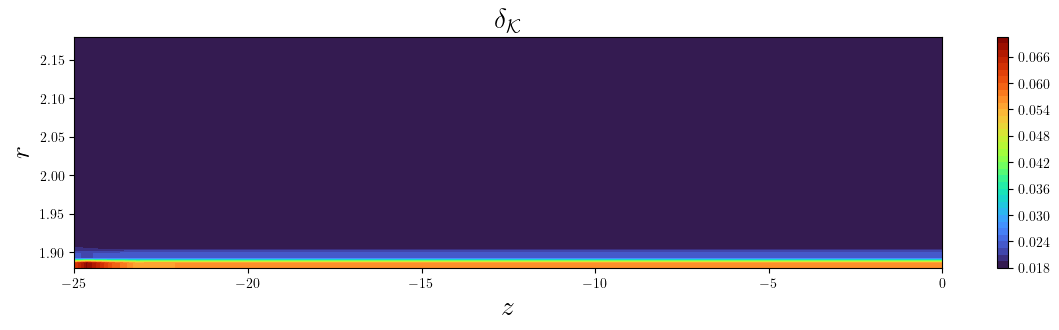

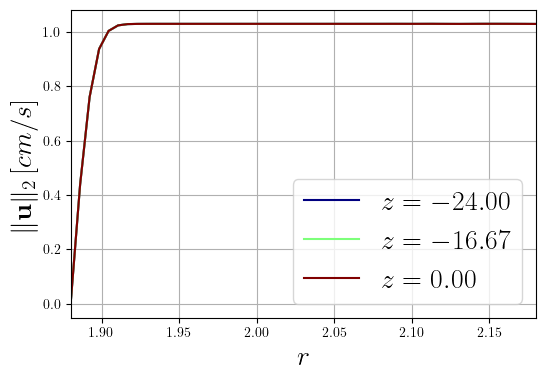

In [5]:
L = 50
R = pitch / 2
clad_or = 1.88

Nx, Ny = 140, 50
x_grid = np.linspace(-L/2, L/2, Nx)
y_grid = np.linspace(clad_or, R, Ny)

u_x_list = []
u_y_list = []
deltaK_list = []
grid_list = [] 

for ii in range(Nx):
    points = np.zeros((3, Ny))
    points[0, :] = x_grid[ii]
    points[1, :] = y_grid

    bb_tree = dolfinx.geometry.BoundingBoxTree(velocityProblem.domain, velocityProblem.domain.topology.dim)
    cells = []
    points_on_proc = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(velocityProblem.domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i))>0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    xPlot = np.array(points_on_proc, dtype=np.float64)

    u_x_list.append(u_sol.sub(0).eval(xPlot, cells).flatten())
    u_y_list.append(u_sol.sub(1).eval(xPlot, cells).flatten())
    deltaK_list.append(velocityProblem.deltaK.eval(xPlot, cells).flatten())
    grid_list.append(xPlot[:,:2])

ux_grid = np.zeros((Nx * Ny,))
uy_grid = np.zeros((Nx * Ny,))
deltaK_grid = np.zeros((Nx * Ny,))
xy_grid  = np.zeros((Nx * Ny, 2))

idx = 0

for ii in range(Nx):
    for jj in range(Ny):
        ux_grid[idx] = u_x_list[ii][jj]
        uy_grid[idx] = u_y_list[ii][jj]
        deltaK_grid[idx] = deltaK_list[ii][jj]
        xy_grid[idx, 0] = grid_list[ii][jj, 0]
        xy_grid[idx, 1] = grid_list[ii][jj, 1]
        idx += 1

from scipy.interpolate import NearestNDInterpolator

ux_fun = NearestNDInterpolator(xy_grid, ux_grid)
uy_fun = NearestNDInterpolator(xy_grid, uy_grid)
deltaK_fun = NearestNDInterpolator(xy_grid, deltaK_grid)

X, Y = np.meshgrid(x_grid, y_grid)
fig = plt.figure( figsize = (14,3) )
plt.contourf(X, Y, np.sqrt(ux_fun(X,Y)**2+uy_fun(X,Y)**2), cmap=cm.jet, levels = 40)
plt.colorbar()
plt.xlim(-L/2, 0)
plt.xlabel(r'$z$', fontsize = 20)
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$\|\mathbf{u}\|_2\,[cm/s]$', fontsize = 20)                    
fig.savefig('U_contour_channel_'+str(Re)+'.pdf', format='pdf', dpi=600, bbox_inches='tight')

fig = plt.figure( figsize = (14,3) )
plt.contourf(X, Y, deltaK_fun(X,Y), cmap=cm.turbo, levels = 40)
plt.colorbar()
plt.xlim(-L/2, 0)
plt.xlabel(r'$z$', fontsize = 20)
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$\delta_\mathcal{K}$', fontsize = 20)
fig.savefig('deltaK_'+str(Re)+'.pdf', format='pdf', dpi=600, bbox_inches='tight')

fig = plt.figure( figsize = (6,4) )
channelArray = np.array([-L/2+1, -L/3, 0.])

color = iter(cm.jet(np.linspace(0, 1, len(channelArray))))
for ii in range(len(channelArray)):
    c = next(color)
    plt.plot(y_grid, np.sqrt(ux_fun(0.,y_grid)**2+uy_fun(0.,y_grid)**2), c=c, label = r'$z = {:.2f}'.format(channelArray[ii])+'$')

plt.xlim(clad_or, R)
plt.legend(loc = 'lower right', fontsize = 20)
plt.xlabel(r'$r$', fontsize = 20)
plt.ylabel(r'$\|\mathbf{u}\|_2\,[cm/s]$', fontsize = 20)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
fig.savefig('U_midChannelProfile_'+str(Re)+'.pdf', format='pdf', dpi=600, bbox_inches='tight')
